## Questions

TODO: Put motivating questions from the report into the this cell

Are students asking conceptual or appllied questions?
Which topics are more prevalent? Where is the most confusion?
    - Topic Modeling
    - Run the same topic model over different intervals of time
What do in-person interactions not already tell us? 
What are areas that need attention in student understanding? 
    - Concrete evidence of topics where students are struggling
Probably don't look at response time
What are people afraid of asking about? (Anonymous posts from students)
Data:
    - Timestamp
    - Userid (student or instructor, throw out announcements)
    - Question or answer? 
    - Votes (good question)
    - Question Text

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import random

from collections import OrderedDict

from utils.analysis_utils import *

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
dfs = glob.glob('data/dataframes/*.p')

In [3]:
# This is done to ensure that the class dataframes are read in chronological order, not by the order 
# by which they appear within the file system.

id_class_map = {}
id_class_map['iqv0bsb3p2i3ch'] = 'Fall 2016 Dewan'
id_class_map['j5wwaj87hvu6af'] = 'Fall 2017 KMP'
id_class_map['jz8ejj1lawb5st'] = 'Spring 2019 Dewan'
id_class_map['jqnyuvgzug4p3'] = 'Spring 2019 KMP'
id_class_map['jkws0l0gvcr7it'] = 'Fall 2019 KMP'

ordered_dfs = [] 
for i in id_class_map:
    for df in dfs:
        if i in df:
            ordered_dfs.append(df)
            
dfs = ordered_dfs

# Get the Piazza network id of each course
network_ids = [re.search(r'dataframe_(.*?)\.p', file_path).group(1) for file_path in dfs]

In [4]:
student_dfs = [] # The un-pickled posts for each 401 Class (student posts)
instructor_dfs = [] # The un-pickled posts for each 401 Class (instructor posts)
lda_output = [] # The output of every LDA model 
all_topic_words = [] # All of the top_n topics for each LDA model 

# Run LDA on the text of every 401 class' posts
for i in range(len(dfs)):
    # Read in the dataframe and only select student posts
    current_df = pd.read_pickle(dfs[i])
        
    # Adding on new features 
    current_df['word_count'] = current_df['text'].map(lambda x: len(x))   
    
    student_df = current_df.query("is_student")
    instructor_df = current_df.query("is_student==False")
        
    student_dfs.append(student_df)
    instructor_dfs.append(instructor_df)
    
    data_list = current_df["text"].tolist()
    lda_output.append(lda_operation(data_list))
    
# Save all of the words found by the topic model for each class
for output in lda_output:
    print_topics(*output)
    all_topic_words.append(save_topics(*output))

Topic 0:
[('object', 473.245826992338), ('method', 473.0698848497688), ('public', 433.8483760124484), ('avatar', 78.17749343190209), ('java', 67.36342224356052), ('string', 66.76094076126462), ('class', 55.612409201265685), ('bridgescene', 33.973430628011975), ('command', 24.778752607343893), ('say', 19.16877476904077)]
Topic 1:
[('assignment', 116.36858741999417), ('just', 81.9748958781488), ('make', 70.77112726254455), ('credit', 67.60467982273158), ('extra', 63.103834729329265), ('property', 62.789773869389286), ('sure', 60.82801136661284), ('class', 55.26405864488637), ('checks', 50.37584092704761), ('way', 49.36150348276771)]
Topic 2:
[('class', 443.93620082669923), ('classes', 214.4326922277121), ('java', 189.01319043855125), ('test', 10.569191232160636), ('method', 5.880642928963928), ('run', 4.062676352932129), ('checks', 1.6993494406814984), ('local', 1.2141394897414708), ('sure', 0.9708629715729377), ('file', 0.9310635750805804)]
Topic 3:
[('java', 771.9682095591825), ('run',

In [5]:
# Get all of the text of the student posts
# TODO: Get all of the text for the instructor posts 
all_text = [''.join(df['text'].tolist()) for df in student_dfs]
all_text = [re.sub(r'(?ui)\\b\\w\w*[a-z]+\\w*\\b', '', text) for text in all_text]

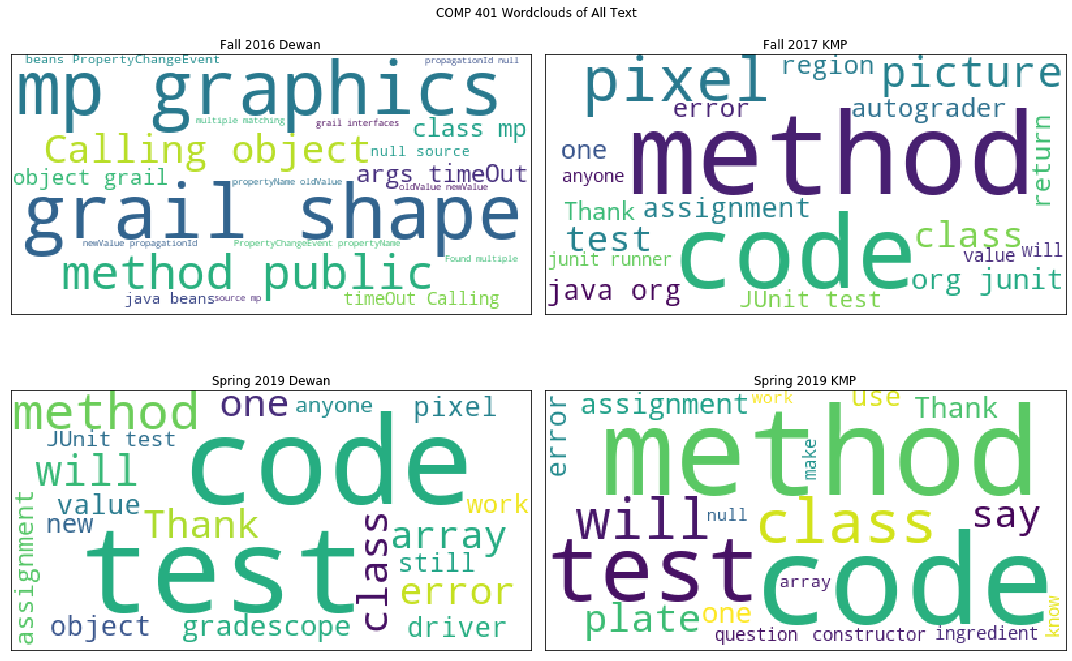

In [6]:
# Plot word clouds of all the currently completed 401 classes
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("COMP 401 Wordclouds of All Text")

ax = ax.flatten()
for i in range(0, 4):
    wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
    wordcloud.generate(all_text[i])
    ax[i].imshow(wordcloud)
    ax[i].set_title(id_class_map[network_ids[i]])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.tight_layout()
plt.savefig('output/all_text_wordclouds')
plt.show()

# Takeaways:

# All of the word clouds are very similar, Dewan's 2016 class is the most complex and has more technical words
# and a lot of stack traces 

# KMP's Spring 2019 section is the simplest, with people asking primarily about administrative things
# Dewan's Spring 2019 section is less technical and complicated than his 2016 section

# Does this mean that the professors are getting better at structuring their assignments over time? 
# Students could be better at reaching out about technical details in office hours
# rather than posting about them in Piazza 

# Students have gotten better about looking for the

# Office hours could have been expanded/improved

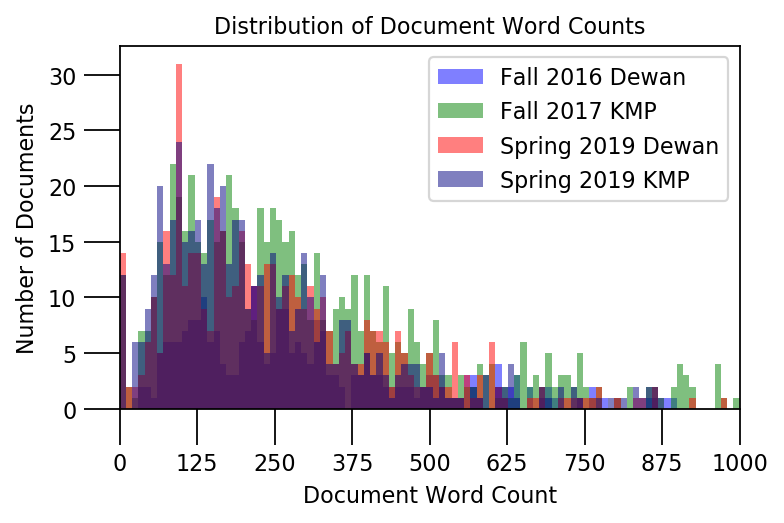

In [7]:
# Plot the distribution of word counts for all completed 401 classes that we have
bins = np.linspace(0, 1000, 100)
colors = ['blue', 'green', 'red', 'navy']

plt.figure(figsize=(5, 3), dpi=160)
for i in range(len(student_dfs)-1):
    plt.hist(student_dfs[i]['word_count'], bins, color=colors[i], alpha=.5, label=id_class_map[network_ids[i]])

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))

plt.legend(loc='upper right')
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))

plt.savefig('output/overlaid_word_counts')
plt.show()

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


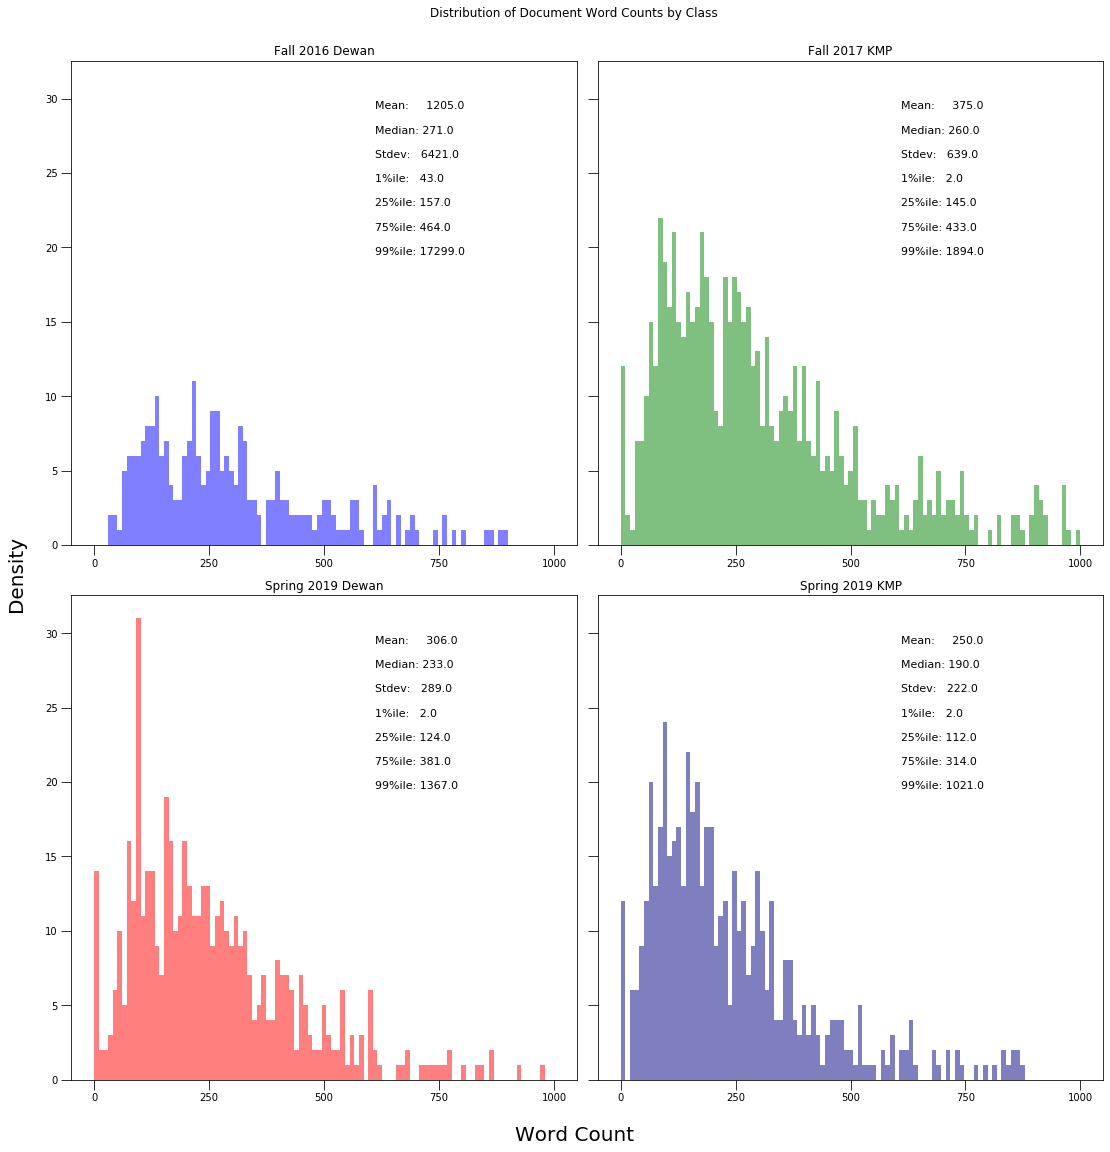

In [8]:
# Plot the distribution of word counts for each class  separately

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=True)
fig.suptitle("Distribution of Document Word Counts by Class", y=1.025)

axs = axs.flatten()
for i in range(len(student_dfs)-1):
    axs[i].hist(student_dfs[i]['word_count'], bins, color=colors[i], alpha=.5)
    axs[i].set_title(id_class_map[network_ids[i]])
    
    # Computation of Summary Statistics
    summary_stats = {}
    summary_stats['Mean'] = str(round(np.mean(student_dfs[i]['word_count'])))
    summary_stats['Median'] = str(round(np.median(student_dfs[i]['word_count'])))
    summary_stats['Stdev'] = str(round(np.std(student_dfs[i]['word_count'])))
    summary_stats['1%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.01)))
    summary_stats['25%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.25)))
    summary_stats['75%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.75)))
    summary_stats['99%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.99)))

    starting_y = .90
    # get max length of the key and add diff as offset
    for k, v in summary_stats.items():
        axs[i].annotate(
            k +': ' + ''.join(' ' * (2*(6-len(k)))) + v,
            (.60, starting_y),
            textcoords='axes fraction',
            size=11)
        
        starting_y -= .05
    
    axs[i].tick_params(size=10)
    axs[i].set_xticks(np.linspace(0, 1000, 5))

fig.tight_layout()
fig.text(0.5, -.025, 'Word Count', ha='center', fontsize=20)
fig.text(-.025, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)

plt.savefig('output/word_counts_by_class')
plt.show()

# Takeaways, all of the classes hav

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


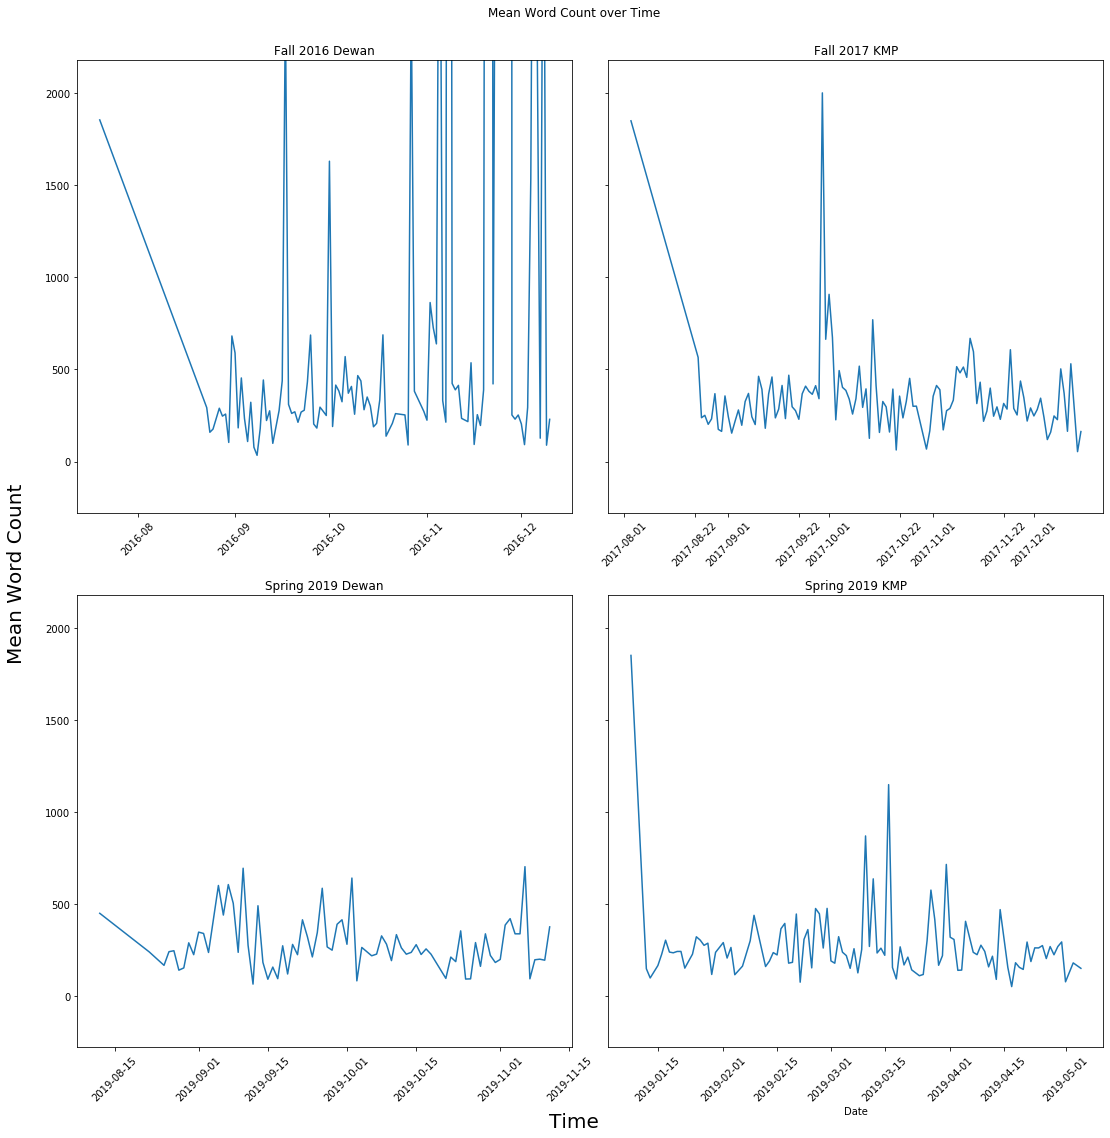

In [9]:
# Plotting mean word count over time
sorted_word_counts = [sorted_word_count(df) for df in student_dfs]
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
months = mdates.MonthLocator()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharex=False, sharey=True)
fig.suptitle("Mean Word Count over Time", y=1.025)

ax = ax.flatten()
for i in range(len(student_dfs)-1):
    wc = sorted_word_counts[i]
    
    y_min, y_max, stdev = min(wc['word_count']), max(wc['word_count']), np.std(wc['word_count'])
    ax[i].set_ylim([y_min - 1.5*stdev, y_max + 1.5*stdev])

    ax[i].plot(wc['created'], wc['word_count'])
    ax[i].set_title(id_class_map[network_ids[i]])
    ax[i].xaxis.set_minor_locator(months)

    plt.sca(ax[i])
    plt.xticks(rotation=45)

fig.tight_layout()
fig.text(0.5, -.0125, 'Time', ha='center', fontsize=20)
fig.text(-.025, 0.5, 'Mean Word Count', va='center', rotation='vertical', fontsize=20)

plt.xlabel("Date")
plt.savefig("output/word_counts_over_time")
plt.show()

In [103]:
# Getting answers for student and instructor type posts
for i in range(len(dfs)):
    fp = dfs[i][16:-2]

    student_df_with_answer = (student_dfs[i]
                             .query("type=='question'"))

    instructor_df_with_answer = (instructor_dfs[i]
                             .query("type=='note'"))
    
    student_ans = []
    for j in range(len(student_df_with_answer['children'])):
        ans = student_df_with_answer['children'].iloc[j]        
        if ans:
            student_ans.append(list(next_content(ans[0])))
        else:
            student_ans.append([''])        
        
    instructor_ans = []
    for j in range(len(instructor_df_with_answer['children'])):
        ans = instructor_df_with_answer['children'].iloc[j]
        if ans:
            instructor_ans.append(list(next_content(ans[0])))
        else:
            instructor_ans.append([''])
            
    student_df_with_answer['answer'] = student_ans
    instructor_df_with_answer['answer'] = instructor_ans
                
    with open(f'data/answers/{fp}_student.p', 'wb') as f:
        pickle.dump(student_df_with_answer, f)
    
    with open(f'data/answers/{fp}_instructor.p', 'wb') as f:
        pickle.dump(instructor_df_with_answer, f)

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
# TODO: Thread responsiveness 
# TODO: Filter questions 
# TODO: Sort by homeworks

# Num Children as proxy for responsiveness

In [14]:
# TODO: Column that is a list of the answer test 

In [15]:
# TODO: Look at instructor only posts as well

In [16]:
# TODO: Look at class syllabi for timing of assignments and midterms to correlate with spikes in different plots

In [17]:
# TODO: Bar chart of top words for topics

In [18]:
# TODO: Types of things that students are looking to answer (conceptual vs. applied)
# TODO: Where is the most confusion, what are students potentially more afraid to ask about? 

In [19]:
# TODO: Question or Answer? 
# TOOO: Num votes/ good question 

In [20]:
# TODO: Simple summary stats with pandas pipeline

In [21]:
# TODO: t_SNE

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/